In [ ]:
from pathlib import Path
import pandas as pd

# EDA

In [ ]:
data_dir = Path("/home/kcv/Desktop/Rate_Capability/Data")

# pick a sample file (first one alphabetically here)
sample_path = sorted(data_dir.glob("RD_RateCapability_*.csv"))[0]
print(f"Inspecting {sample_path.name}")

df = pd.read_csv(sample_path)

display(df.head())          # peek at the first rows
display(df.describe())      # quick stats for numeric columns
print(df.dtypes)            # column types

# # Optional: plot a few key channels
# ax = df.plot(x="Test_Time(s)", y=["Voltage(V)", "Current(A)"], figsize=(10, 4))
# ax.set_title(sample_path.name)
# ax.set_ylabel("Value")

In [ ]:
df.columns

In [ ]:
df['cycle no'].unique()

# 1. Sanity Check: Review the test setup for rate capability tests in cycle data and step data.

In [ ]:
unique_tuples = df[['cycle no', 'step no', 'step name']].drop_duplicates().itertuples(index=False, name=None)
list(unique_tuples)

# 2
Identify the Current values for charge and discharge corresponding to C rates (0.1C, 0.2C, 0.3C, 0.4C and 0.5C) Use Mean current to calculate c-rate


# 3
Identify the number of cycles where a particular C rate is repeated in the whole testing process. For example, 0.2C charge is repeated 3 times. So, 3 cycles of data is available for 0.2C charge.

In [ ]:
from pathlib import Path
import pandas as pd

data_dir = Path("/home/kcv/Desktop/Rate_Capability/Data")
out_path = Path("/home/kcv/Desktop/Rate_Capability/results/data/c_rate_stats.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)

all_stats = []
for csv_path in sorted(data_dir.glob("RD_RateCapability_*.csv")):
    df = pd.read_csv(csv_path)

    stats['cell_name'] = csv_path.stem

    stats = (
        df.groupby(['cycle no', 'step no', 'step name'], as_index=False)
          .agg(mean_current=('current(a)', 'mean'),
               max_current=('current(a)', 'max'),
               min_current=('current(a)', 'min'))
    )
    stats['mean_c_rate'] = stats['mean_current'] / 150
    stats['max_c_rate'] = stats['max_current'] / 150
    stats['min_c_rate'] = stats['min_current'] / 150
         # add file name (without extension)

    all_stats.append(stats)

combined_stats = pd.concat(all_stats, ignore_index=True)
combined_stats.to_csv(out_path, index=False)
print(f"Saved {len(combined_stats)} rows to {out_path}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MultipleLocator
from pathlib import Path

stat_prefixes = ["mean","max","min"]
stats = pd.read_csv(f"/home/kcv/Desktop/Rate_Capability/results/data/c_rate_stats.csv")

for prefix in stat_prefixes:

    

    plots_dir = Path("/home/kcv/Desktop/Rate_Capability/results/plots")
    plots_dir.mkdir(parents=True, exist_ok=True)
    pdf_path = plots_dir / f"c_rate_{prefix}_cycle_step_all_cells.pdf"

    with PdfPages(pdf_path) as pdf:
        for cell_name, cell_stats in stats.groupby('cell_name'):
            cell_stats = cell_stats.sort_values(['cycle no', 'step no']).reset_index(drop=True)
            x_idx = np.arange(len(cell_stats))
            y = cell_stats[f'{prefix}_c_rate']

            step_cats = pd.Categorical(cell_stats['step name'])
            norm = max(1, len(step_cats.categories) - 1)
            color_lookup = {name: plt.cm.tab20(i / norm) for i, name in enumerate(step_cats.categories)}
            colors = cell_stats['step name'].map(color_lookup)

            fig, ax_cycle = plt.subplots(figsize=(12, 5))
            ax_cycle.scatter(x_idx, y, c=colors, s=60, edgecolor='k', linewidth=0.4)
            ax_cycle.set_xticks(x_idx)
            ax_cycle.set_xticklabels(cell_stats['cycle no'])
            ax_cycle.set_xlabel('Cycle Number')
            ax_cycle.set_ylabel('C-rate')

            ax_cycle.yaxis.set_major_locator(MultipleLocator(0.1))
            ymin = np.floor(y.min() * 10) / 10
            ymax = np.ceil(y.max() * 10) / 10
            ax_cycle.set_ylim(ymin, ymax)

            ax_step = ax_cycle.twiny()
            ax_step.set_xlim(ax_cycle.get_xlim())
            ax_step.set_xticks(x_idx)
            ax_step.set_xticklabels(cell_stats['step no'], rotation=90, ha='center')
            ax_step.set_xlabel('Step Number')

            step_numbers = (
                cell_stats[['step name', 'step no']]
                .drop_duplicates()
                .groupby('step name')['step no']
                .apply(lambda s: ', '.join(str(int(v)) if float(v).is_integer() else str(v) for v in sorted(s)))
            )
            handles = [
                plt.Line2D([], [], marker='o', linestyle='', color=color_lookup[name],
                        label=f"{name} (steps {nums})")
                for name, nums in step_numbers.items()
            ]
            ax_cycle.legend(handles=handles, title='Step Name / Step Nos',
                            bbox_to_anchor=(0.5, -0.18), loc='upper center', frameon=False)

            ax_cycle.set_title(f'{cell_name} - C-rate {prefix} by Cycle and Step', pad=20)

            fig.subplots_adjust(top=0.85, bottom=0.33)  # reserve space for title/legend

            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

    print(f"Saved multi-page PDF to {pdf_path}")


# 4. Q-V plots

In [ ]:
from utils.QV import export_qv_grid_pdf

export_qv_grid_pdf(
    data_dir="Data",
    stats_csv="results/data/c_rate_stats.csv",
    output_pdf="results/plots/qv_cycle_stepname_all_cells.pdf",
    include_rest=False
)


# 5. Save SOC Data

Normalize the Capacity values to SoC in a scale of 0 to 100 for every step.



In [ ]:
from utils.SOCV import (
    save_soc_data,
    plot_socv_by_step,
    plot_cycle_steps_socv,
    plot_cell_socv_grid,
    export_socv_grid_pdf,
)


In [ ]:
from pathlib import Path
from utils.SOCV import save_soc_data   # re-exported for convenience

data_dir = Path("Data")
output_dir = Path("results/data/soc_data")
output_dir.mkdir(parents=True, exist_ok=True)

for csv_path in sorted(data_dir.glob("RD_RateCapability_*.csv")):
    _, saved_path = save_soc_data(csv_path, output_dir)
    print(f"Saved SoC data to {saved_path}")


# 6. SOC Knee Detection

After normalization, prepare the plots of Voltage vs SoC for all the C-rates corresponding to the number of cycles for all steps. Metric: Quantify shift in knee point. For each cycle,step plot for all c-rates.

### Knee point detection 
Bacon-Watts Method (Ref: https://arxiv.org/pdf/2201.02891)

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from pwlf import PiecewiseLinFit
import plotly.graph_objects as go

cell_file = Path("results/data/soc_data/RD_RateCapability_0001_soc_data.csv")
cycle= 1

for step in [18,8]:

    trace = (
        pd.read_csv(cell_file)
        .query("`cycle no` == @cycle and `step no` == @step")
        .sort_values("soc(%)")
    )

    soc = trace["soc(%)"].values
    volt = trace["volt(v)"].values

    # Fit 7 segments (6 interior breakpoints)
    model = PiecewiseLinFit(soc, volt)
    breakpoints = model.fit(7)                       # length = 7 + 1 = 8 breakpoints
    piece_x = np.linspace(soc.min(), soc.max(), 1000)
    piece_y = model.predict(piece_x)

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=soc, y=volt,
        mode="lines",
        name="SoC–Voltage",
        line=dict(color="royalblue")
    ))

    fig.add_trace(go.Scatter(
        x=piece_x, y=piece_y,
        mode="lines",
        name="Piecewise Fit",
        line=dict(color="darkorange", dash="dash")
    ))

    # all interior breakpoints
    inner_breaks = breakpoints[1:-1]
    inner_volts = model.predict(inner_breaks)
    fig.add_trace(go.Scatter(
        x=inner_breaks,
        y=inner_volts,
        mode="markers+text",
        name="Breakpoints",
        marker=dict(color="crimson", size=9),
        text=[f"{s:.1f}%<br>{v:.3f}V" for s, v in zip(inner_breaks, inner_volts)],
        textposition="top center"
    ))

    # highlight breakpoint #2 and #6 (1-indexed interior breakpoints)
    if len(inner_breaks) >= 6:
        bp2_soc = inner_breaks[1]
        bp2_volt = inner_volts[1]
        bp6_soc = inner_breaks[5]
        bp6_volt = inner_volts[5]
        fig.add_trace(go.Scatter(
            x=[bp2_soc, bp6_soc],
            y=[bp2_volt, bp6_volt],
            mode="markers+text",
            name="Breakpoints 2 & 6",
            marker=dict(color="black", size=11, symbol="x"),
            text=[f"BP2 {bp2_soc:.1f}%<br>{bp2_volt:.3f}V",
                f"BP6 {bp6_soc:.1f}%<br>{bp6_volt:.3f}V"],
            textposition="bottom center"
        ))

    if step ==18:
        step_name = 'CC_DChg'
    else: step_name = 'CCCV_Chg'

    fig.update_layout(
        title=f"Cycle {cycle} Step {step} {step_name}— Piecewise Fit Breakpoints",
        xaxis_title="State of Charge (%)",
        yaxis_title="Voltage (V)",
        template="plotly_white",
        margin=dict(t=70)
    )

    fig.show()

    print("Breakpoints (SoC % → Voltage V):")
    for s in inner_breaks:
        v = model.predict([s])[0]
        print(f"  {s:.2f}% → {v:.3f} V")


Breakpoints (SoC % → Voltage V):
  1.48% → 2.776 V
  4.17% → 2.988 V
  7.66% → 3.083 V
  25.64% → 3.181 V
  76.46% → 3.246 V
  99.05% → 3.256 V


Breakpoints (SoC % → Voltage V):
  1.41% → 3.036 V
  5.14% → 3.254 V
  25.62% → 3.350 V
  43.80% → 3.356 V
  94.03% → 3.419 V
  97.94% → 3.466 V


# Save and plot Knee Points

#### Testing for one cell

In [1]:
from utils.knee_summary import save_knee_summary

save_knee_summary(
    data_dir="Data",
    stats_csv="results/data/c_rate_stats.csv",
    soc_data_dir="results/data/soc_data",
    output_csv="results/data/soc_knee_summary.csv",
    cell_names=["RD_RateCapability_0001"],  # process only this cell
    include_rest=False,
    processes=None  # or None to auto-detect cores
)

PosixPath('results/data/soc_knee_summary.csv')

In [ ]:
from utils.knee_summary import save_knee_summary

save_knee_summary(
    data_dir="Data",
    stats_csv="results/data/c_rate_stats.csv",
    soc_data_dir="results/data/soc_data",
    output_csv="results/data/soc_knee_summary.csv",
    cell_names=["RD_RateCapability_0001"]   # only this cell
)

/home/kcv/Desktop/Rate_Capability/.venv/lib/python3.12/site-packages/pwlf/pwlf.py:1248: RuntimeWarning: invalid value encountered in divide
  self.slopes = np.divide(


PosixPath('results/data/soc_knee_summary.csv')

/home/kcv/Desktop/Rate_Capability/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1309: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2) / (dx1 * (dx1 + dx2))
/home/kcv/Desktop/Rate_Capability/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1310: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/kcv/Desktop/Rate_Capability/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1311: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/kcv/Desktop/Rate_Capability/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1317: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] \


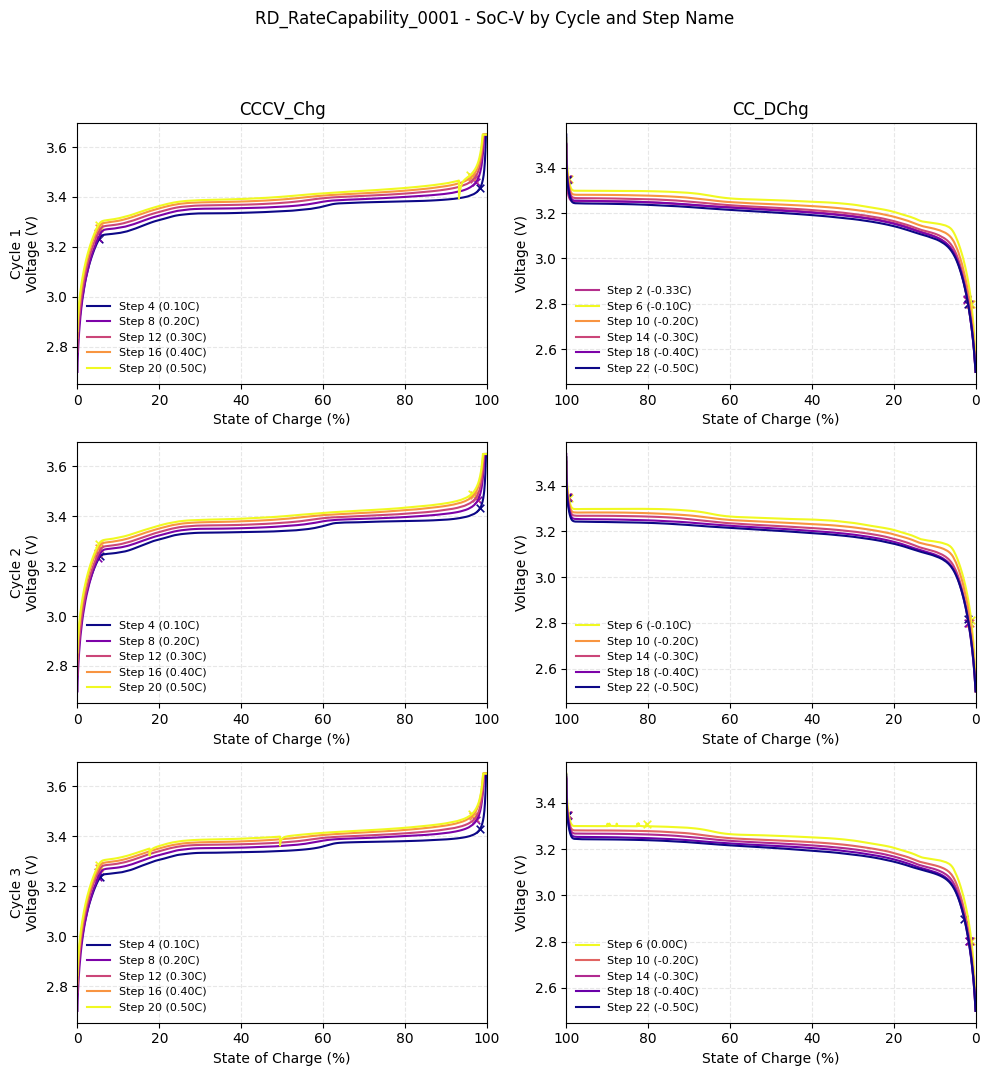

(<Figure size 1000x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'CCCV_Chg'}, xlabel='State of Charge (%)', ylabel='Cycle 1\nVoltage (V)'>,
         <Axes: title={'center': 'CC_DChg'}, xlabel='State of Charge (%)', ylabel='Voltage (V)'>],
        [<Axes: xlabel='State of Charge (%)', ylabel='Cycle 2\nVoltage (V)'>,
         <Axes: xlabel='State of Charge (%)', ylabel='Voltage (V)'>],
        [<Axes: xlabel='State of Charge (%)', ylabel='Cycle 3\nVoltage (V)'>,
         <Axes: xlabel='State of Charge (%)', ylabel='Voltage (V)'>]],
       dtype=object))

In [2]:
from utils.soc_plots import plot_cell_socv_grid, export_socv_grid_pdf

# view a single cell’s SoC grid
plot_cell_socv_grid(
    cell_csv="Data/RD_RateCapability_0001.csv",
    stats_csv="results/data/c_rate_stats.csv",
    include_rest=False,
    soc_data_dir="results/data/soc_data"
)

In [ ]:
# ### Saving SoC vs V summary for all cells
# from utils.knee_summary import save_knee_summary

# save_knee_summary(
#     data_dir="Data",
#     stats_csv="results/data/c_rate_stats.csv",
#     soc_data_dir="results/data/soc_data",          # where per-cell SoC CSVs live (or will be written)
#     output_csv="results/data/soc_knee_summary.csv"
# )
### Saving soc v plots for all cells
# # produce a multi-page PDF (one page per cell)
# export_socv_grid_pdf(
#     data_dir="Data",
#     stats_csv="results/data/c_rate_stats.csv",
#     output_pdf="results/plots/socv_cycle_stepname_all_cells.pdf",
#     include_rest=False,
#     soc_data_dir="results/data/soc_data"
# )